In [279]:
# https://github.com/MasashiSode/mcs_kfold/blob/master/mcs_kfold/mcs_kfold.py

In [13]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple, Optional
from functools import cached_property
from tqdm import tqdm

import json
import re
import base64
import zlib
import PIL.Image
import PIL.ImageDraw
import PIL.ImageFont
import numpy as np
import io
import palettable
import sys
import contextlib
import sklearn.model_selection
import pandas as pd
import enum
import shutil
import random

# pillow >= 10


class OutputMode(enum.Enum):
    BOXES = 1
    MASKS = 2


class Transform:
    def __init__(self, scale=1, tx=0, ty=0):
        self.s = scale
        self.tx = tx
        self.ty = ty
        
        
class ScaleOptions:
    megapixel: float
    fixed_width: float
    longest_edge: float

        
class Mask:
    def __init__(self, image: Image, mask: np.array):
        self.image = image
        self.mask = mask
        assert tuple(image.size) == tuple(mask.shape[::-1])
        
    def save(self, path: Path):
        im = PIL.Image.fromarray(self.mask, "P")
        im.save(path)
        
    def scale(self, size=800):
        if max(self.image.size) <= size:
            return self
        else:
            image = self.image.scale(size)
            return image.mask
        
    def _plot(self):
        if self.image.labels:
            catalog = self.image.labels[0].category.catalog
            colors = catalog.palette.colors
        else:
            colors = None
            
        palette_data = []
        i = 0
        while len(palette_data) < 256:
            palette_data.extend(colors[i % len(colors)])
            i += 1
        
        # ensure white for "unlabeled"
        palette_data[0] = 255
        palette_data[1] = 255
        palette_data[2] = 255
                
        mask = PIL.Image.fromarray(self.mask, "P")
        mask.putpalette(palette_data)
                 
        with self.image.image() as im:
            im = im.convert("RGB")
            mask = mask.convert("RGB")
            return PIL.Image.blend(im, mask, 0.75)
            
        
    def plot(self, size=800):
        return self.scale(size)._plot()
    
        
class Crop:
    def __init__(self, category: Category, im: PIL.Image, parent:Image = None, bbox: BBox = None):
        self.category = category
        self._im = im
        self.parent = parent
        self.bbox = bbox
    
    @property
    def filename(self):
        p = Path(self.parent.filename).stem
        cx = int((self.bbox.minx + self.bbox.maxx) / 2)
        cy = int((self.bbox.miny + self.bbox.maxy) / 2)
        return f"{self.category.name}_{p}_{cx}_{cy}.png"
    
    def save(self, path: Path):
        self._im.save(path)
            
    def _repr_png_(self):
        return self._im._repr_png_()
        
        
class Image:
    def __init__(self, size: Tuple, labels: List[Label] = None):
        self._size = size
        self.labels = labels or []
    
    def ensure_no_duplicate_labels(self):
        data = dict()
        for label in self.labels:
            key = tuple(label.region.bbox.xyxy)
            if key in data:
                raise ValueError("duplicate label!")
            data[key] = label
 
    @property
    def size(self):
        return self._size

    def scale(self, max_size: int):
        w, h = self._size
        ratio = min(1, max_size / max(w, h))
        if ratio >= 1:
            return self
        else:
            with self.image() as im:
                im2 = im.resize(
                    (int(w * ratio), int(h * ratio)))
                t = Transform(ratio)
                return DetachedImage(
                    im2,
                    [x.transform(t) for x in self.labels],
                    parent=self)

    @property
    def category_vector(self):
        return np.sum([x.category.vector for x in self.labels], axis=0)
    
    @property
    def crops(self):
        with self.image() as im:
            for label in self.labels:
                xyxy = label.region.bbox.xyxy
                yield Crop(
                    label.category, im.crop(xyxy),
                    parent=self, bbox=label.region.bbox)
    
    @property
    def mask(self):
        if not self.labels:
            return None
        
        unlabeled = self.labels[0].category.catalog.unlabeled
        if unlabeled is None:
            raise RuntimeError("please set OutputMode.MASKS")
        
        w, h = self._size
        arr = np.empty((h, w), dtype=np.uint8)
        arr.fill(unlabeled.index)
        for label in self.labels:
            label.region.fill_mask(arr, label.category.index)

        return Mask(self, arr)

    def _repr_png_(self):
        return self.scale(800)._plot()._repr_png_()

    def plot(self, font=None, size=800):
        return self.scale(size)._plot(font)

    def _plot(self, font: PIL.ImageFont = None):
        if font is None:
            font = PIL.ImageFont.load_default()
        
        if self.labels:
            colors = self.labels[0].category.catalog.palette.hex_colors
        else:
            colors = None

        with self.image() as im:
            draw = PIL.ImageDraw.Draw(im)

            for label in self.labels:
                color = colors[label.category.index % len(colors)]
                label.region.draw(im, draw, color)

                if font is None:
                    continue

                if label.confidence is None:
                    text = label.category.name
                else:
                    text = f"{label.category.name} ({label.confidence * 100:.2f}%)"

                left, top, right, bottom = font.getbbox(text)
                text_size = (right - left, bottom - top)

                text_im = PIL.Image.new('L', text_size)
                text_draw = PIL.ImageDraw.Draw(text_im, 'L')
                text_draw.text((-left, -top), text, font=font, fill=255)
                white = PIL.Image.new('RGB', text_size, (255, 255, 255))

                x1, y1, x2, y2 = label.region.bbox.xyxy

                for dx in (-2, -1, 1, 2):
                    for dy in (-2, -1, 1, 2):
                        im.paste(white, (
                            int(x1 + 4 + dx + left),
                            int(y2 + 4 + dy + top)), text_im)

                black = PIL.Image.new('RGB', text_size, (0, 0, 0))
                im.paste(black, (
                    int(x1 + 4 + left),
                    int(y2 + 4 + top)), text_im)

            return im
    
    
class DetachedImage(Image):
    def __init__(self, im: PIL.Image, labels: List[Label], parent: Image = None, ext: str = None):
        super().__init__(im.size, labels)
        for label in labels:
            label.image = self
        self._im = im
        self.parent = parent
        self.ext = ext or ""
        
    def save(self, path: Path):
        self._im.save(path)

    def with_labels(self, labels: List[Label]):
        return DetachedImage(self._im, labels, parent=self.parent)
        
    @contextlib.contextmanager
    def image(self):
        yield self._im.copy()

    @property
    def filename(self):
        exts = []
        x = self
        while isinstance(x, DetachedImage):
            if x.ext:
                exts.append(x.ext)
            x = x.parent
        ext = "_".join(reversed(exts)) if exts else ""
        return x.path.stem + ext + x.path.suffix
        
        
class CatalogImage(Image):
    def __init__(self, path: Path, labels: List[Label] = None):
        with PIL.Image.open(path) as im:
            size = im.size
        super().__init__(size, labels)
        self.path = path
                
    def save(self, path: Path):
        shutil.copy(self.path, path)

    def with_labels(self, labels: List[Label]):
        return CatalogImage(self.path, labels)
        
    @contextlib.contextmanager
    def image(self):
        with PIL.Image.open(self.path) as im:
            yield im

    @property
    def filename(self):
        return self.path.name
    
    
class Category:
    def __init__(self, catalog: CategoryCatalog, name: str, index: int):
        self.catalog = catalog
        self.name = name
        self.index = index
        
    @property
    def vector(self):
        v = np.zeros((len(self.catalog),), dtype=np.float32)
        v[self.index] = 1
        return v

    def __repr__(self):
        return f"{self.index}[{self.name}]"
    
    def __eq__(self, other: Category):
        return isinstance(other, Category) and \
            self.name == other.name
    
    def __hash__(self):
        return self.index
    
    
class BBox:
    def __init__(self, minx, miny, maxx, maxy):
        self.minx = minx
        self.miny = miny
        self.maxx = maxx
        self.maxy = maxy
        
    @property
    def width(self):
        return self.maxx - self.minx

    @property
    def height(self):
        return self.maxy - self.miny

    @property
    def xyxy(self):
        return self.minx, self.miny, self.maxx, self.maxy
    
    
class Region:
    @property
    def bbox(self):
        raise NotImplementedError()

    def yolo_bbox(self, image: Image):
        # COCO is (x, y, w, h), absolute; https://cocodataset.org/#format-data
        # YOLO is (x, y, w, h), relative (0 to 1);  are center of rectangle (are not top-left corner)
        # see https://github.com/AlexeyAB/Yolo_mark/issues/60
        bbox = self.bbox
        size = image.size
        yolo = [
            ((bbox.minx + bbox.maxx) / 2) / size[0],
            ((bbox.miny + bbox.maxy) / 2) / size[1],
            bbox.width / size[0],
            bbox.height / size[1]
        ]
        return yolo


class CocoBox(Region):
    # COCO is (x, y, w, h), absolute; https://cocodataset.org/#format-data
    def __init__(self, x, y, w, h):
        self._x = x
        self._y = y
        self._w = w
        self._h = h
        
    def __repr__(self):
        return f"[{self.minx},{self.miny},{self.maxx},{self.maxy}]"

    @property
    def bbox(self):
        return BBox(self.minx, self.miny, self.maxx, self.maxy)

    def transform(self, t: Transform):
        return CocoBBox(
            self._x * t.s + t.tx,
            self._y * t.s + t.ty,
            self._w * t.s,
            self._h * t.s)

    @property
    def width(self):
        return self._w

    @property
    def height(self):
        return self._h
    
    @property
    def minx(self):
        return self._x

    @property
    def miny(self):
        return self._y

    @property
    def maxx(self):
        return self._x + self._w
    
    @property
    def maxy(self):
        return self._y + self._h
    
    @property
    def coco(self):
        return self._x, self._y, self._w, self._h
        
    def draw(self, im: PIL.Image, draw: PIL.ImageDraw, color):
        x1, y1, x2, y2 = self.bbox
        draw.rectangle(
            [x1, y1, x2, y2],
            outline=color, width=3)
            

def base64_2_mask(s):
    # https://docs.supervisely.com/data-organization/00_ann_format_navi/04_supervisely_format_objects
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = PIL.Image.open(io.BytesIO(n))
    return mask


class BitmapRegion(Region):
    def __init__(self, mask: PIL.Image, origin: Tuple):
        self.mask = mask
        self.origin = origin
        
    def __repr__(self):
        return f"[{self.minx},{self.miny},{self.maxx},{self.maxy}]"
        
    @property
    def bbox(self):
        x, y = self.origin
        w, h = self.mask.size
        return BBox(x, y, x + w, y + h)

    def transform(self, t: Transform):
        w, h = self.mask.size
        return BitmapRegion(
            self.mask.resize((int(w * t.s), int(h * t.s))),
            (int(self.origin[0] * t.s + t.tx), int(self.origin[1] * t.s + t.ty)))
    
    @property
    def width(self):
        return self.mask.width

    @property
    def height(self):
        return self.mask.height
    
    @property
    def minx(self):
        return self.origin[0]

    @property
    def miny(self):
        return self.origin[1]

    @property
    def maxx(self):
        return self.origin[0] + self.mask.width
    
    @property
    def maxy(self):
        return self.origin[1] + self.mask.height
    
    @cached_property
    def transparent_mask(self):
        mask = self.mask.convert("L")
        arr = np.array(mask)
        return PIL.Image.fromarray(arr * 128)
        
    def draw(self, im: PIL.Image, draw: PIL.ImageDraw, color):
        block = PIL.Image.new('RGB', self.mask.size, color)
        
        im.paste(
            block,
            tuple(map(int, self.origin)),
            self.transparent_mask)
        
        x1, y1, x2, y2 = self.bbox.xyxy
        draw.rectangle(
            [x1, y1, x2, y2],
            outline=color, width=3)
        
    def fill_mask(self, arr: np.array, i: int):
        bitmap = np.array(self.mask.convert("1"))
        x1, y1, x2, y2 = self.bbox.xyxy
        arr_region = arr[y1:y2, x1:x2]
        #print(arr_region.shape, bitmap.shape, x2 - x1, y2 - y1)
        assert arr_region.shape == bitmap.shape
        arr_region[bitmap] = i
            

class Label:
    image: Image
    category: Category
    region: Region
    confidence: float
    
    def __init__(self, image: Image, region: Region, category: Category):
        self.image = image
        self.region = region
        self.category = category
        self.confidence = None
        
    def __repr__(self):
        return f"Label(category={self.category}, region={self.region})"
    
    @property
    def bbox(self):
        return self.region.bbox
    
    def transform(self, t: Transform):
        return Label(self.image, self.region.transform(t), self.category)

    def remap_category(self, catalog: CategoryCatalog):
        return Label(self.image, self.region, catalog.add(self.category.name))
    
    def yolo_str(self):
        return " ".join(
            [str(self.category.index)] + [str(float(x)) for x in self.region.yolo_bbox(self.image)])

    
class CategoryCatalog:
    categories: Dict[str, Category]
    unlabeled: Optional[Category]
    output_mode: OutputMode
    
    def __init__(self, output_mode: OutputMode):
        self.categories = dict()
        if output_mode == OutputMode.MASKS:
            self.unlabeled = self.add("unlabeled")
        else:
            self.unlabeled = None
        self.output_mode = output_mode
        self.palette = palettable.colorbrewer.qualitative.Accent_8

    def __len__(self):
        return len(self.categories)
        
    def items(self):
        return self.categories.items()
    
    def tolist(self):
        return [x[1] for x in sorted(
            (cat.index, cat) for cat in self.categories.values())]
    
    def add(self, key: str) -> Category:
        cat = self.categories.get(key)
        if cat is None:
            i = len(self.categories)
            cat = Category(self, key, i)
            self.categories[key] = cat
        return cat
    
    
class Dataset:
    def __init__(self, images: List[Image], catalog: CategoryCatalog):
        if not images:
            print("WARNING: created Dataset from empty set")
        for image in images:
            image.ensure_no_duplicate_labels()
        self.images = images
        self.category_catalog = catalog
    
    @property
    def crops(self):
        for image in self.images:
            yield from image.crops

    def sample(self, n: int):
        images = random.choices(
            self.images,
            weights=[len(x.labels) for x in self.images],
            k=min(n, len(self.images)))
        return Dataset(images, catalog=self.category_catalog)
        
    def filter(self, categories: List[str]):
        cat_set = set(categories)

        catalog = CategoryCatalog(
            self.category_catalog.output_mode)
        
        cat_images = list()
        for image in self.images:
            f_labels = list()
            for label in image.labels:
                if label.category.name in cat_set:
                    f_labels.append(
                        label.remap_category(catalog))
            if f_labels:
                cat_images.append(
                    image.with_labels(f_labels))
                                
        return Dataset(
            cat_images, catalog=catalog)
        
    def to_non_overlapping_sets(self):
        raise NotImplementedError()
        
    def to_single_class_sets(self):
        categories = set()
        for image in self.images:
            for label in image.labels:
                categories.add(label.category)

        sets = dict()
        for category in categories:
            sets[category.name] = self.filter([category.name])
            
        return sets
                
    def scale(self, max_size: int, storage_path: Path = None):
        images = list()
        for x in tqdm(self.images, desc="scale"):
            images.append(x.scale(max_size))
        return Dataset(images, catalog=self.category_catalog)
 
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return self.images[i]
    
    def mask(self, i):
        unlabeled = self.category_catalog.add("unlabeled")
        return self.images[i].create_mask(unlabeled=unlabeled.index)
    
    @property
    def categories(self):
        return [x.name for x in self.category_catalog.tolist()]
    
    def partition(self):
        new_images = list()
        for image in tqdm(self.images, desc="partition"):
            partition = Partition(image)
            for new_image in partition:
                new_images.append(new_image)
        return Dataset(
            new_images,
            catalog=self.category_catalog)
        
    @property
    def population(self):
        y = np.array([x.category_vector for x in self.images])
        pop = dict()
        for category, count in zip(self.category_catalog.tolist(), np.sum(y, axis=0)):
            pop[category.name] = int(count)
        return pop
    
    def kfold(self, num_folds=5):
        y = np.array([x.category_vector for x in self.images])
        
        def subset(ind):
            return Dataset(
                [self.images[i] for i in ind],
                catalog=self.category_catalog)

        total = np.sum(y.astype(np.bool_).astype(np.float32), axis=1)
        if np.max(total) > 1:
            print("kfold is best guess.")
        
        y = np.argmax(y, axis=1)  # best effort single-class label
            
        kfold = sklearn.model_selection.StratifiedKFold(
            num_folds, shuffle=True, random_state=100)

        folds = list()
        for fold_index, (train_ind, val_ind) in enumerate(kfold.split(
            np.arange(len(self.images)), y=y)):

            folds.append({
                'train': subset(train_ind),
                'val': subset(val_ind)
            })

        return folds
            
    def _mc_stratified_kfold(self, num_folds=5):
        y = np.array([x.category_vector for x in self.images])
        columns = [str(i + 1) for i in range(y.shape[1])]
        df = pd.DataFrame(y, columns=columns)

        mcskf = MCSKFold(
            n_splits=num_folds, shuffle_mc=True, max_iter=100)
        
        for fold, (train_idx, valid_idx) in enumerate(
            mcskf.split(df=df, target_cols=columns)):
            
            print(fold)

    def plot_sample(self, max_images=30, size=150):
        import ipyplot

        images = random.choices(
            self.images,
            weights=[len(x.labels) for x in self.images],
            k=min(max_images, len(self.images)))
        
        ims = list()
        for image in tqdm(images):
            im = image.plot(size=size).convert("RGB")
            print(im.size)
            ims.append(im)

        ipyplot.plot_images(ims, img_width=size * 2)
            
    #def _repr_png_(self):
    #    # https://matplotlib.org/stable/gallery/axes_grid1/simple_axesgrid.html
    #    pass
    
    
class ImageCatalog:
    _images: Dict[str, Image]

    def __init__(self):
        self._images = dict()

    def clean(self):
        taken = dict()
        skipped = list()
        for key, x in self._images.items():
            if x.labels:
                taken[key] = x
            else:
                skipped.append(x)
        if len(skipped) > 0:
            print(
                f"removed {len(skipped)} images as they have no labels: ",
                [str(x.path) for x in skipped])
        self._images = taken
        
    @property
    def images(self):
        return list(self._images.values())

    def add(self, key: str, path: Path) -> Image:
        image = self._images.get(key)
        if image is None:
            image = CatalogImage(path)
            self._images[key] = image
        return image
                

class Importer:
    image_catalog: ImageCatalog
    category_catalog: CategoryCatalog
    
    def __init__(self, output_mode=OutputMode.BOXES):
        self.image_catalog = ImageCatalog()
        self.category_catalog = CategoryCatalog(output_mode)
        self.min_size = 32
        self.output_mode = output_mode
        
    @property
    def images(self) -> Dataset:
        return Dataset(
            self.image_catalog.images,
            self.category_catalog)
        
    @staticmethod
    def load(p: Path, format_: str, output_mode: OutputMode):
        p = Path(p)
        imp = Importer(output_mode)
        for x in sorted(p.iterdir()):
            if x.is_dir() and not x.name.startswith("."):
                imp.add(x, format_)
        imp.image_catalog.clean()
        return imp.images
    
    def add(self, p: Path, format_: str):
        if format_ == "supervisely":
            self.add_supervisely(p)
        elif format_ == "coco":
            self.add_coco(p)
        else:
            raise ValueError(format)
    
    def add_supervisely(self, path: Path):
        path = Path(path)
        skip_count = 0

        for p in sorted((path / "ann").iterdir()):
            if p.suffix == ".json":
                filename = p.stem
                
                image = self.image_catalog.add(
                    filename,
                    path / "img" / filename)
                
                with open(p, "r") as f:
                    ann = json.loads(f.read())
                for obj in ann["objects"]:
                    #print(obj)
                    category = self.category_catalog.add(obj["classTitle"])
                    region = BitmapRegion(
                        base64_2_mask(obj["bitmap"]["data"]),
                        obj["bitmap"]["origin"])
                    if region.width < self.min_size or region.height < self.min_size:
                        skip_count += 1
                        continue
                    image.labels.append(Label(image, region, category))
                    
        if skip_count > 0:
            print(f"skipped {skip_count} labels in {path}")

    def add_coco(self, path):
        path = Path(path)
        skip_count = 0

        with open(path / "annotations" / "instances.json", "r") as f:
            instances = json.loads(f.read())

        categories = dict()
        for record in instances["categories"]:
            categories[record["id"]] = record["name"]

        image_records = dict()
        for record in instances["images"]:
            image_records[record["id"]] = record

        for record in instances["annotations"]:
            image_record = image_records[record["image_id"]]
            bbox = CocoBox(*record["bbox"])
            if bbox.width < self.min_size or bbox.height < self.min_size:
                skip_count += 1
                continue
            filename = image_record["file_name"]

            image = self.image_catalog.add(
                filename,
                path / "images" / filename)
            
            image.labels.append(Label(
                image,
                bbox,
                self.category_catalog.add(
                    categories[record["category_id"]])
            ))
                  
        if skip_count > 0:
            print(f"skipped {skip_count} labels in {path}")


In [14]:
dset = Importer.load(
    "/Users/ch/Downloads/255511_Alchemische-Objekte-supervisely",
    format_="supervisely",
    output_mode=OutputMode.MASKS)

skipped 1 labels in /Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/mineral-metal
skipped 4 labels in /Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/ollae
skipped 1 labels in /Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/other-equipment
removed 18 images as they have no labels:  ['/Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/cucurbitae/img/Distilierbuch1545-048.png', '/Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/cucurbitae-ambix/img/Distilierbuch1545-024.png', '/Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/cucurbitae-ambix/img/Kerzenmacher1589-Alchimia-017.png', '/Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/cucurbitae-retorte/img/Campesii1572-Coelum-300.png', '/Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/cucurbitae-rosenhut/img/Brunschwig1512-DeArteDistillandi-563.png', '/Users/ch/Downloads/255511_Alchemische-Objekte-supervisely/cucurbitae-rosenhut/img/Giglio1559-Pirotechnia-553.png

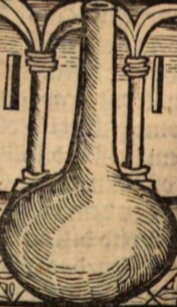

In [15]:
next(dset.crops)

In [18]:
def save_crops(dset: Dataset, path: Path):
    path = Path(path)
    for crop in tqdm(dset.crops):
        crop.save(path / crop.filename)
        
save_crops(dset, "/Users/ch/Desktop/yolo-crops")

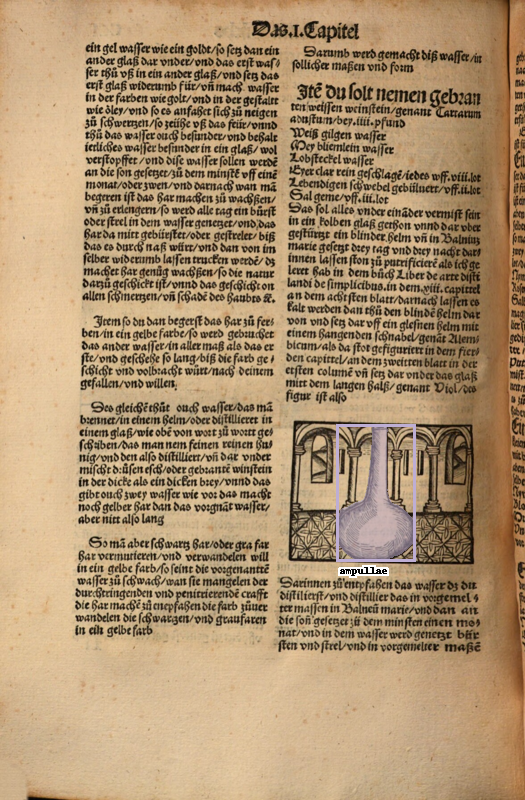

In [110]:
dset[0]

In [79]:
dset.to_single_class_sets()

{'ampullae': <__main__.Dataset at 0x2cfefd4e0>,
 'animal': <__main__.Dataset at 0x2cfefd630>,
 'cucurbitae-ambix': <__main__.Dataset at 0x2cfefd900>,
 'cucurbitae': <__main__.Dataset at 0x2cfefdde0>,
 'furnace': <__main__.Dataset at 0x2cfefe3e0>,
 'cucurbitae-rosenhut': <__main__.Dataset at 0x2cfeff5e0>,
 'other-equipment': <__main__.Dataset at 0x2cfeffa00>,
 'cucurbitae-retorte': <__main__.Dataset at 0x2cff40220>,
 'ollae': <__main__.Dataset at 0x2cff404c0>,
 'human': <__main__.Dataset at 0x2cff40a00>,
 'mineral-metal': <__main__.Dataset at 0x2cff40d30>,
 'plant': <__main__.Dataset at 0x2cff41450>}

In [735]:
#images.resize(640)

100%|███████████████████████████████████████████████████████████████| 111/111 [00:10<00:00, 10.44it/s]


In [726]:
if sys.platform == "darwin":
    font_path = "Courier"
else:
    font_path = "/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf"

font = PIL.ImageFont.truetype(
    font_path, 12)

In [727]:
images.population

{'unlabeled': 0,
 'ampullae': 14,
 'animal': 16,
 'cucurbitae-ambix': 16,
 'cucurbitae': 22,
 'furnace': 57,
 'cucurbitae-rosenhut': 10,
 'other-equipment': 54,
 'cucurbitae-retorte': 7,
 'ollae': 43,
 'human': 18,
 'mineral-metal': 34,
 'plant': 4}

In [728]:
images.categories

['unlabeled',
 'ampullae',
 'animal',
 'cucurbitae-ambix',
 'cucurbitae',
 'furnace',
 'cucurbitae-rosenhut',
 'other-equipment',
 'cucurbitae-retorte',
 'ollae',
 'human',
 'mineral-metal',
 'plant']

(630, 367) (630, 367) 367 630
(366, 194) (366, 194) 194 366
(778, 453) (778, 453) 453 778
(75, 43) (75, 43) 43 75
(43, 23) (43, 23) 23 43
(93, 54) (93, 54) 54 93


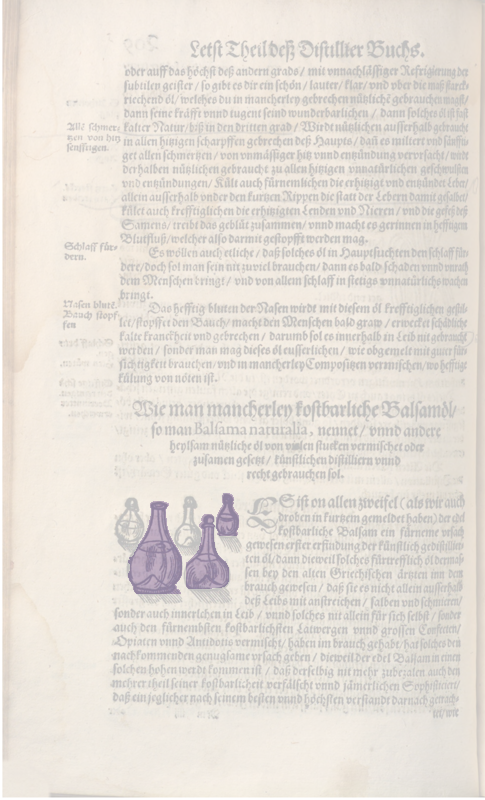

In [729]:
images[1].mask.plot()

In [629]:
folds = dset.images.kfold(3)
folds

[{'train': <__main__.ImageCollection at 0x2ef7cb8b0>,
  'val': <__main__.ImageCollection at 0x2ef69fc70>},
 {'train': <__main__.ImageCollection at 0x2efaefc70>,
  'val': <__main__.ImageCollection at 0x2efaf4910>},
 {'train': <__main__.ImageCollection at 0x2ef803eb0>,
  'val': <__main__.ImageCollection at 0x2ef775150>}]

In [454]:
folds[0]["train"].population()

{'ampullae': 8,
 'animal': 9,
 'cucurbitae-ambix': 11,
 'cucurbitae': 12,
 'furnace': 36,
 'cucurbitae-rosenhut': 7,
 'other-equipment': 40,
 'cucurbitae-retorte': 2,
 'ollae': 32,
 'human': 10,
 'mineral-metal': 20,
 'plant': 3}

In [124]:
def axis_split(intervals: List, optimum: float):
    events = []
    for i, (iv_min, iv_max) in enumerate(intervals):
        events.append((iv_min, ('add', i)))
        events.append((iv_max, ('remove', i)))
    events = sorted(events)
    active = set()
    candidates = list()
    for i, (x, (event, iv_index)) in enumerate(events):
        if event == 'add':
            active.add(iv_index)
        elif event == 'remove':
            active.remove(iv_index)
        if len(active) == 0 and i < len(events) - 1:
            candidates.append(i)
    if not candidates:
        return False
    else:
        xs = [(events[i][0] + events[i + 1][0]) / 2 for i in candidates]
        errs = [abs(x - optimum) for x in xs]
        j = np.argmin(errs)
        return xs[j], errs[j]

        #m = len(events) // 2
        #j = np.argmin([abs(i - m) for i in candidates])
            
            
def best_split(boxes, size):
    split = False
    
    split_x = axis_split(
        [[box.minx, box.maxx] for box in boxes],
        size[0] / 2)
    split_y = axis_split(
        [[box.miny, box.maxy] for box in boxes],
        size[1] / 2)

    if split_x and split_y:
        if split_x[1] / size[0] < split_y[1] / size[1]:
            split = ('x', split_x[0])
        else:
            split = ('y', split_y[0])
    elif split_x:
        split = ('x', split_x[0])
    elif split_y:
        split = ('y', split_y[0])
        
    return split


class Node:
    def __init__(self, labels: List[Label], origin, size, addr):
        self.origin = origin
        self.size = size
        self.addr = addr
        
        split = best_split(
            [x.bbox for x in labels], size)

        if split:
            axis, x = split
            
            if axis == "x":
                left = list()
                right = list()

                for label in labels:
                    if label.bbox.maxx < x:
                        left.append(label)
                    else:
                        right.append(label.transform(Transform(tx=-x)))

                a = Node(left, origin, [x, size[1]], addr + "l")
                b = Node(right, [origin[0] + x, origin[1]], [size[0] - x, size[1]], addr + "r")
                self.children = [a, b]
                self.labels = None
                        
            elif axis == "y":
                lower = list()
                upper = list()
                
                for label in labels:
                    if label.bbox.maxy < x:
                        upper.append(label)
                    else:
                        lower.append(label.transform(Transform(ty=-x)))

                a = Node(upper, origin, [size[0], x], addr + "t")
                b = Node(lower, [origin[0], origin[1] + x], [size[0], size[1] - x], addr + "b")
                self.children = [a, b]
                self.labels = None
                        
        else:
            self.children = []
            self.labels = labels
            
    @property
    def bounds(self):
        x, y = self.origin
        w, h = self.size
        return [x, y, x + w, y + h]
            
    @property
    def descendants(self):
        if self.children:
            r = list()
            for x in self.children:
                r.extend(x.descendants)
            return r
        else:
            return [self]
        


class Partition:
    def __init__(self, image: Image):
        self.image = image
        root = Node(image.labels, [0, 0], image.size, "")
        self.nodes = root.descendants

    def __len__(self):
        return len(self.nodes)
        
    def __getitem__(self, part: int):
        node = self.nodes[part]
        with self.image.image() as im:
            cropped = im.crop(node.bounds)
        return DetachedImage(
            cropped, node.labels,
            parent=self.image,
            ext=f"_S{node.addr}" if node.addr else "")

In [125]:
partition = Partition(dset.images[5])

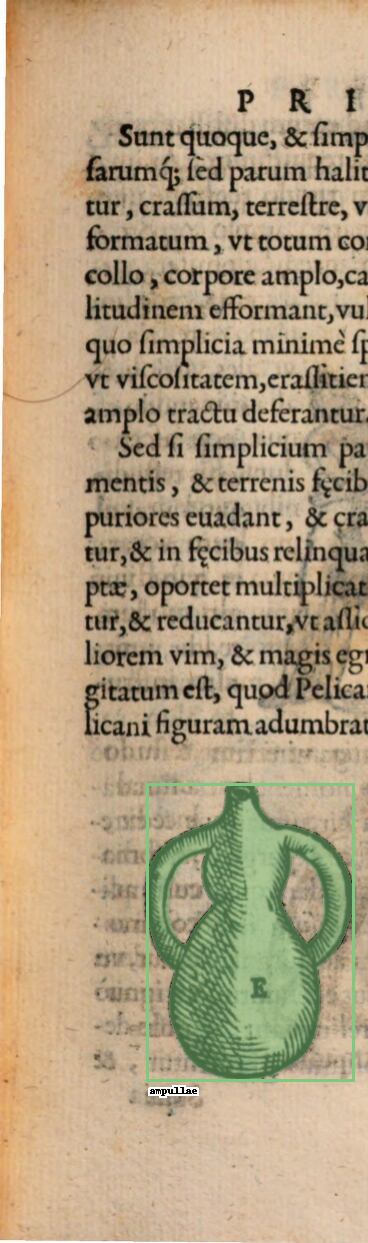

In [459]:
partition[0]

In [460]:
len(dset.images)

111

In [461]:
len(dset.images.partition())

225

In [171]:
import matplotlib.pyplot as plt
import collections

class Exporter:
    def kfold(self, path: Path, dset: Dataset, num_folds: int, exist_ok=False):
        path = Path(path)
        path.mkdir(exist_ok=exist_ok)
        folds = dset.kfold(num_folds)
        for i, fold in enumerate(folds):
            self.write_train_val(
                path / f"fold{i + 1}",
                fold["train"],
                fold["val"],
                exist_ok=exist_ok)

    def sets(self, path: Path, sets: Dict, num_folds: int, exist_ok=False):
        path = Path(path)
        path.mkdir(exist_ok=exist_ok)
        for k, v in tqdm(sets.items()):
            self.kfold(
                path / k,
                v,
                num_folds=num_folds)            
            
            
class MaskExporter(Exporter):
    def _write_dset(self, path: Path, dset: Dataset):
        #if dset.output_mode != OutputMode.MASKS:
        #    raise ValueError("please set output mode to MASKS")
            
        path.mkdir(exist_ok=False)
        (path / "images").mkdir(exist_ok=False)
        (path / "masks").mkdir(exist_ok=False)
        
        for image in dset:
            filename = image.filename
            image.save(path / "images" / filename)
            image.mask.save((path / "masks" / filename).with_suffix(".png"))
        
    
    def write_train_val(self, path: Path, train: Dataset, valid: Dataset, exist_ok=False):
        categories = train.categories
        assert categories == valid.categories

        path = Path(path)
        if exist_ok and path.exists():
            if (path / "train").exists():
                shutil.rmtree(path / "train")
            if (path / "valid").exists():
                shutil.rmtree(path / "valid")
        else:
            path.mkdir(exist_ok=False)
            
        count_train = self._write_dset(path / "train", train)
        count_valid = self._write_dset(path / "valid", valid)
        
        with open(path / "dataset.json", "w") as f:
            f.write(json.dumps({
                'categories': categories
            }))
        
            
            
class YoloExporter(Exporter):
    def _write_yolo_dset(self, path: Path, dset: Dataset):
        if dset.output_mode != OutputMode.BOXES:
            raise ValueError("please set output mode to BOXES")
        
        path.mkdir(exist_ok=False)
        (path / "images").mkdir(exist_ok=False)
        (path / "labels").mkdir(exist_ok=False)

        counts = collections.Counter()

        for image in dset:
            filename = image.filename
            image.save(path / "images" / filename)

            with open((path / "labels" / filename).with_suffix(".txt"), "w") as f:
                for label in image.labels:
                    f.write(label.yolo_str() + "\n")
                    counts[label.category.name] += 1

        return counts

    def write_train_val(self, path: Path, train: Dataset, valid: Dataset, exist_ok=False):
        categories = train.categories
        assert categories == valid.categories

        path = Path(path)
        if exist_ok and path.exists():
            if (path / "train").exists():
                shutil.rmtree(path / "train")
            if (path / "valid").exists():
                shutil.rmtree(path / "valid")
        else:
            path.mkdir(exist_ok=False)

        count_train = self._write_yolo_dset(path / "train", train)
        count_valid = self._write_yolo_dset(path / "valid", valid)

        with open(path / "dataset.yaml", "w") as f:
            f.write(f"train: train/images\n")
            f.write(f"val: valid/images\n")
            f.write("\n")
            f.write(f"nc: {len(categories)}")
            f.write("\n")
            f.write("# Classes\n")
            f.write(f"names: {categories}\n")

        fig, (ax1, ax2) = plt.subplots(
            1, 2, figsize=(16, 4), sharex=True, sharey=True)
        ax1.set_title('train')
        ax2.set_title('valid')
        ax1.tick_params(axis='x', labelrotation=90)
        ax2.tick_params(axis='x', labelrotation=90)
        x_cats = sorted(set(count_train.keys()) | set(count_valid.keys()))
        ax1.bar(x_cats, [count_train.get(x, 0) for x in x_cats])
        ax2.bar(x_cats, [count_valid.get(x, 0) for x in x_cats])
        plt.tight_layout()
        fig.savefig(path / "dataset.png")
        plt.close()


In [169]:
dset2 = dset.partition().scale(640)

scale: 100%|████████████████████████████████████████████████████████| 225/225 [00:02<00:00, 91.21it/s]


In [163]:
sets = dset2.to_single_class_sets()
sets

{'ampullae': <__main__.Dataset at 0x53c6124a0>,
 'animal': <__main__.Dataset at 0x53c612fb0>,
 'cucurbitae-ambix': <__main__.Dataset at 0x53c613d30>,
 'cucurbitae': <__main__.Dataset at 0x53c654970>,
 'furnace': <__main__.Dataset at 0x53c655b70>,
 'cucurbitae-rosenhut': <__main__.Dataset at 0x53c5ac6d0>,
 'other-equipment': <__main__.Dataset at 0x53c5acfd0>,
 'cucurbitae-retorte': <__main__.Dataset at 0x53c5af5b0>,
 'ollae': <__main__.Dataset at 0x53c5afc10>,
 'human': <__main__.Dataset at 0x53c629c30>,
 'mineral-metal': <__main__.Dataset at 0x53c62aa70>,
 'plant': <__main__.Dataset at 0x53c62c430>}

In [164]:
len(sets["ampullae"])

12

In [151]:
#sets["ampullae"].kfold(3)

In [88]:
dset2 = dset.partition()

partition: 100%|████████████████████████████████████████████████████| 111/111 [00:15<00:00,  6.95it/s]


In [90]:
len(dset2.filter(["ampullae"]))

12

In [91]:
sets = dset2.to_single_class_sets()
sets

{'ampullae': <__main__.Dataset at 0x2af948b80>,
 'animal': <__main__.Dataset at 0x2af94bf40>,
 'cucurbitae-ambix': <__main__.Dataset at 0x2af94b190>,
 'cucurbitae': <__main__.Dataset at 0x2af948d90>,
 'furnace': <__main__.Dataset at 0x2af949c30>,
 'cucurbitae-rosenhut': <__main__.Dataset at 0x2af9d0b80>,
 'other-equipment': <__main__.Dataset at 0x2af9d3010>,
 'cucurbitae-retorte': <__main__.Dataset at 0x2af9d07f0>,
 'ollae': <__main__.Dataset at 0x2af9d2f50>,
 'human': <__main__.Dataset at 0x2af9d1630>,
 'mineral-metal': <__main__.Dataset at 0x2af9d1db0>,
 'plant': <__main__.Dataset at 0x2af9d25c0>}

In [92]:
len(sets["ampullae"])

12

In [93]:
dset3 = dset2.scale(640)

scale: 100%|████████████████████████████████████████████████████████| 225/225 [00:02<00:00, 94.07it/s]


In [95]:
sets = dset3.to_single_class_sets()
sets

{'ampullae': <__main__.Dataset at 0x2afb2c040>,
 'animal': <__main__.Dataset at 0x2afb2c3d0>,
 'cucurbitae-ambix': <__main__.Dataset at 0x2afc13a30>,
 'cucurbitae': <__main__.Dataset at 0x2afc6f670>,
 'furnace': <__main__.Dataset at 0x2afc6d540>,
 'cucurbitae-rosenhut': <__main__.Dataset at 0x2afc6d030>,
 'other-equipment': <__main__.Dataset at 0x2afc6c160>,
 'cucurbitae-retorte': <__main__.Dataset at 0x2aff46fe0>,
 'ollae': <__main__.Dataset at 0x2aff47010>,
 'human': <__main__.Dataset at 0x2aff44670>,
 'mineral-metal': <__main__.Dataset at 0x2aff45240>,
 'plant': <__main__.Dataset at 0x2afc17be0>}

In [96]:
len(sets["ampullae"])

12

In [160]:
exporter = YoloExporter()
exporter.sets("/Users/ch/Desktop/yolo-dset", sets, num_folds=3)

100%|█████████████████████████████████████████████████████████████████| 12/12 [00:56<00:00,  4.70s/it]


In [ ]:
# masks


In [165]:
sets["ampullae"].categories

['unlabeled', 'ampullae']

In [173]:
mask_exporter = MaskExporter()
mask_exporter.kfold("/Users/ch/Desktop/yolo-dset-mask", dset2, num_folds=3)

kfold is best guess.
(109, 63) (109, 63) 63 109
(74, 43) (74, 43) 43 74
(225, 160) (225, 160) 160 225
(216, 132) (216, 132) 132 216
(166, 142) (166, 142) 142 166
(212, 153) (212, 153) 153 212
(38, 39) (38, 39) 39 38
(44, 29) (44, 29) 29 44
(27, 45) (27, 45) 45 27
(38, 47) (38, 47) 47 38
(61, 52) (61, 52) 52 61
(112, 154) (112, 154) 154 112
(46, 31) (46, 31) 31 46
(29, 19) (29, 19) 19 29
(121, 78) (121, 78) 78 121
(76, 73) (76, 73) 73 76
(62, 96) (62, 96) 96 62
(156, 221) (156, 221) 221 156
(55, 179) (55, 179) 179 55
(110, 163) (110, 163) 163 110
(64, 105) (64, 105) 105 64
(100, 70) (100, 70) 70 100
(94, 71) (94, 71) 71 94
(87, 123) (87, 123) 123 87
(96, 69) (96, 69) 69 96
(98, 153) (98, 153) 153 98
(105, 68) (105, 68) 68 105
(188, 126) (188, 126) 126 188
(70, 47) (70, 47) 47 70
(204, 74) (204, 74) 74 204
(71, 45) (71, 45) 45 71
(168, 108) (168, 108) 108 168
(200, 120) (200, 120) 120 200
(197, 129) (197, 129) 129 197
(103, 92) (103, 92) 92 103
(106, 91) (106, 91) 91 106
(35, 37) (35, 37